In [26]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from scipy.stats import randint, uniform
import statsmodels.api as sm
from rich.console import Console
from rich.table import Table
from rich.live import Live
from rich import box

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

import xgboost as xgb
from catboost import CatBoostRegressor

### Câu 1. Giá thuê phòng trọ thay đổi như thế nào giữa các quận khác nhau ở TP.HCM?


Thong ke gia thue theo quan (Trieu dong):
                 count  mean  median   min   max
district                                        
Quận Bình Thạnh   3098  4.68     4.8  0.75  27.0
Quận 10           1057  4.09     4.5  0.60  12.0
Quận Phú Nhuận     871  4.45     4.5  0.70  13.5
Quận Tân Bình     2828  4.00     4.0  0.35  29.0
Quận 7            1304  4.11     4.0  0.65  13.0
Quận Gò Vấp       2223  3.56     3.6  0.50  28.0
Quận Tân Phú      1688  3.60     3.6  0.50  23.0
Quận 9            1009  3.19     3.3  0.10  20.0
Quận 12           1065  2.99     3.0  0.60  10.5
Quận Bình Tân     1053  3.00     3.0  0.75  10.0


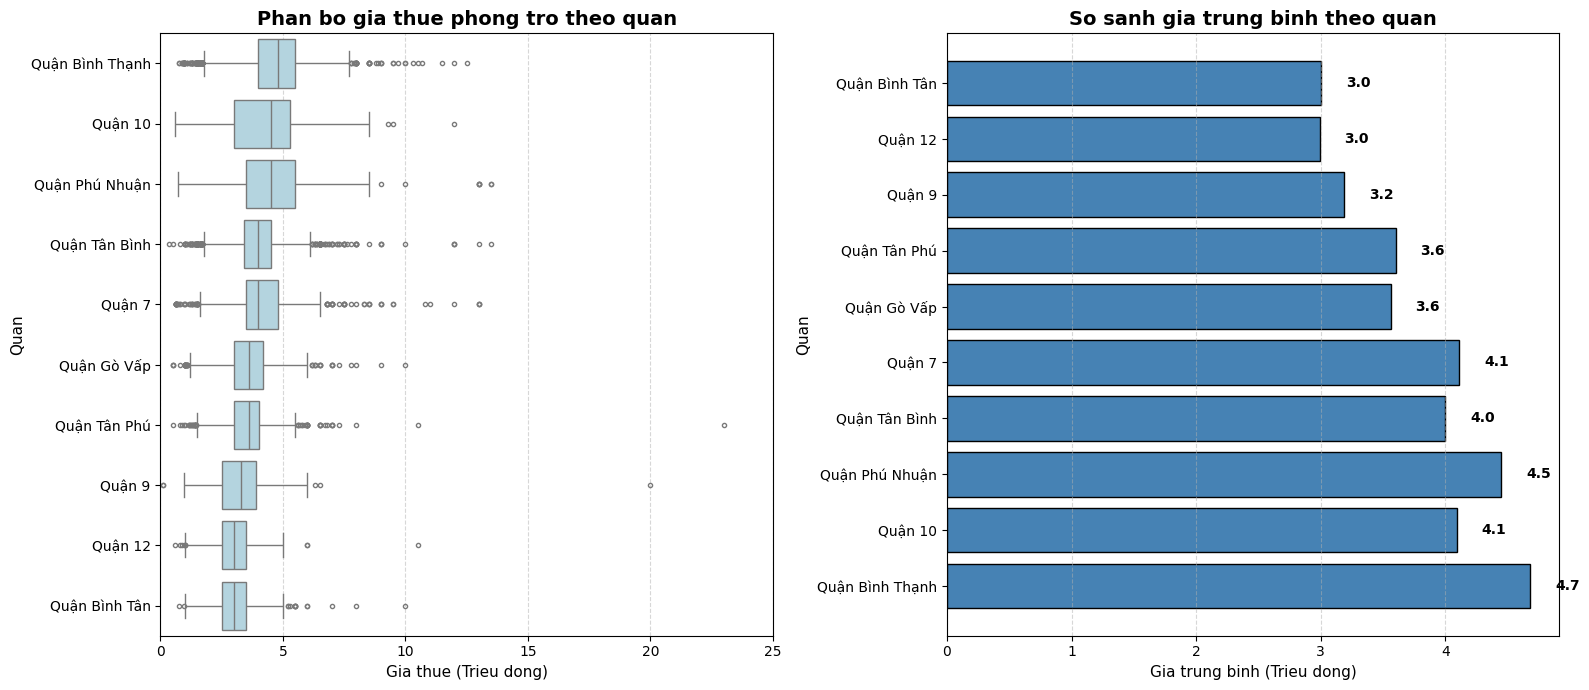


=> Quan co gia cao nhat: Quận Bình Thạnh (4.80 trieu)
=> Quan co gia thap nhat: Quận Bình Tân (3.00 trieu)


In [27]:
df = pd.read_csv("../Data/cleaned.csv")
df = df.drop(columns=['title', 'description', 'url'])

# Tách tên quận từ cột address
df['district'] = df['address'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) else x)

# Lọc top 10 quận có nhiều tin đăng nhất
top_districts = df['district'].value_counts().nlargest(10).index
df_filtered = df[df['district'].isin(top_districts)].copy()

# Loại bỏ outliers cực đoan (giá > 30 triệu, có thể là lỗi dữ liệu)
df_clean = df_filtered[df_filtered['price'] <= 30].copy()

# Tính thống kê giá thuê theo quận
price_stats = df_clean.groupby('district')['price'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('min', 'min'),
    ('max', 'max')
]).sort_values('median', ascending=False).round(2)

print("\nThong ke gia thue theo quan (Trieu dong):")
print(price_stats)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Boxplot - Phân bố giá
sns.boxplot(data=df_clean, x='price', y='district', 
            order=price_stats.index, color='lightblue', 
            showfliers=True, fliersize=3, ax=axes[0])
axes[0].set_title('Phan bo gia thue phong tro theo quan', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Gia thue (Trieu dong)', fontsize=11)
axes[0].set_ylabel('Quan', fontsize=11)
axes[0].set_xlim(0, 25)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# 2. Biểu đồ cột - So sánh giá trung bình
bars = axes[1].barh(price_stats.index, price_stats['mean'], color='steelblue', edgecolor='black')
axes[1].set_title('So sanh gia trung binh theo quan', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Gia trung binh (Trieu dong)', fontsize=11)
axes[1].set_ylabel('Quan', fontsize=11)
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

for i, (idx, val) in enumerate(price_stats['mean'].items()):
    axes[1].text(val + 0.2, i, f'{val:.1f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n=> Quan co gia cao nhat: {price_stats.index[0]} ({price_stats.iloc[0]['median']:.2f} trieu)")
print(f"=> Quan co gia thap nhat: {price_stats.index[-1]} ({price_stats.iloc[-1]['median']:.2f} trieu)")

Dựa trên dữ liệu thu thập được từ 10 quận, ta thấy có sự phân hóa rõ rệt về mức giá thuê phòng trọ, phản ánh vị trí địa lý và mức độ phát triển của từng khu vực. Cụ thể:

### 1. Phân cấp nhóm giá theo khu vực

Có thể chia các quận thành 3 nhóm giá thuê chính dựa trên mức trung vị (median):

**Nhóm giá cao (Trung vị từ 4.5 - 4.8 triệu/tháng):**
- Dẫn đầu là Quận Bình Thạnh với mức giá trung vị cao nhất (4.8 triệu) và cũng là quận có số lượng tin đăng nhiều nhất (3098 tin), cho thấy đây là "điểm nóng" về nhu cầu nhà ở.
- Tiếp theo là Quận Phú Nhuận và Quận 10 cùng mức trung vị 4.5 triệu. Đây là các quận trung tâm hoặc sát trung tâm, thuận tiện giao thông nên mặt bằng giá được thiết lập ở mức cao.

**Nhóm giá trung bình (Trung vị từ 3.6 - 4.0 triệu/tháng):**
- Bao gồm Quận 7 và Quận Tân Bình (4.0 triệu), theo sau là Quận Gò Vấp và Quận Tân Phú (3.6 triệu).
- Đây là phân khúc sôi động với lượng dữ liệu lớn (đặc biệt là Tân Bình và Gò Vấp), phù hợp với đại đa số người đi làm và sinh viên có thu nhập khá.

**Nhóm giá rẻ (Trung vị từ 3.0 - 3.3 triệu/tháng):**
- Gồm Quận 9 (3.3 triệu), Quận 12 và Quận Bình Tân (3.0 triệu).
- Đây là các quận vùng ven, xa trung tâm hơn, phù hợp cho đối tượng ưu tiên tiết kiệm chi phí. Chênh lệch giá trung vị giữa quận cao nhất (Bình Thạnh) và thấp nhất (Bình Tân) lên tới 1.8 triệu đồng/tháng.

### 2. Sự biến động giá (Độ phân tán dữ liệu)

Biểu đồ Boxplot cho thấy sự đa dạng về loại hình phòng trọ trong cùng một quận:

**Biên độ dao động lớn nhất:**
- Quận Tân Bình và Quận Gò Vấp tuy có giá trung bình thuộc nhóm giữa, nhưng lại ghi nhận các giá trị ngoại lai (outliers) cực lớn (Max lần lượt là 29 triệu và 28 triệu). Điều này cho thấy tại đây tồn tại song song cả phân khúc phòng trọ bình dân và các căn hộ dịch vụ cao cấp.

**Biên độ dao động ổn định:**
- Các quận như Quận 12 hay Bình Tân có hộp (box) ngắn hơn và ít điểm ngoại lai đột biến hơn, cho thấy giá thuê tại đây khá đồng đều và tập trung chủ yếu ở phân khúc bình dân.

**Trường hợp Quận 9:**
- Mặc dù giá trung vị thấp (3.3 triệu) nhưng khoảng giá trải rất rộng (từ 0.1 triệu đến 20 triệu), phản ánh sự pha trộn giữa các khu trọ sinh viên giá rẻ (Làng đại học) và các khu căn hộ cao cấp mới nổi.

### 3. Kết luận

Giá thuê phòng trọ tại TP.HCM không đồng nhất mà giảm dần từ các quận trung tâm/sát trung tâm ra phía ngoại thành. Quận Bình Thạnh là khu vực đắt đỏ và sầm uất nhất, trong khi Quận Bình Tân và Quận 12 là lựa chọn tối ưu về chi phí. Đáng chú ý, các quận như Tân Bình hay Gò Vấp cung cấp sự lựa chọn đa dạng nhất, đáp ứng được cả nhu cầu bình dân lẫn cao cấp.

### 2. Tiện nghi nào là ranh giới để phân biệt 2 loại phòng bình dân và cao cấp?

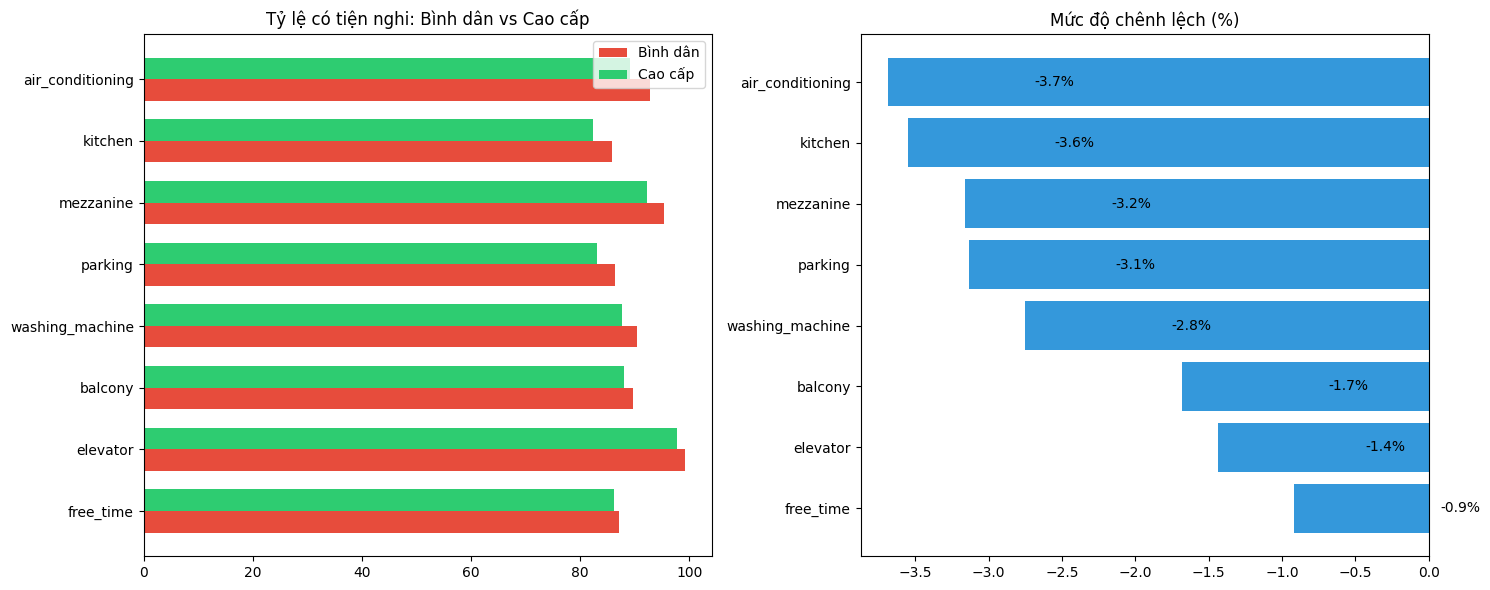

Ngưỡng giá phân loại:
- Bình dân: < 2.9 triệu
- Cao cấp: > 4.6 triệu

Top 5 tiện nghi phân biệt rõ nhất:
free_time         -0.916501
elevator          -1.433288
balcony           -1.682193
washing_machine   -2.754559
parking           -3.134497
Name: Chenh lech, dtype: float64


In [28]:
exclude_cols = ['title', 'price', 'area', 'address', 'description', 'url', 'district', 'ward', 'phone', 'author_name', 'time']
amenity_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['int64', 'float64', 'bool']]

# 2. Phân loại phòng 
q25 = df['price'].quantile(0.25)
q75 = df['price'].quantile(0.75)

df['loai_phong'] = pd.cut(df['price'], 
                           bins=[-1, q25, q75, float('inf')], 
                           labels=['Binh dan', 'Trung cap', 'Cao cap'])

# 3. Tính toán tỷ lệ
amenity_comparison = pd.DataFrame()
for amenity in amenity_cols:
    rates = df.groupby('loai_phong', observed=False)[amenity].mean() * 100 
    amenity_comparison[amenity] = rates

amenity_comparison = amenity_comparison.T
# Tính chênh lệch
if 'Cao cap' in amenity_comparison.columns and 'Binh dan' in amenity_comparison.columns:
    amenity_comparison['Chenh lech'] = amenity_comparison['Cao cap'] - amenity_comparison['Binh dan']

top_diff = amenity_comparison['Chenh lech'].sort_values(ascending=False).head(10)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: So sánh trực tiếp
top_amenities = top_diff.index[:8]
data_plot = amenity_comparison.loc[top_amenities, ['Binh dan', 'Cao cap']]
x = np.arange(len(top_amenities))
width = 0.35

axes[0].barh(x - width/2, data_plot['Binh dan'], width, label='Bình dân', color='#e74c3c')
axes[0].barh(x + width/2, data_plot['Cao cap'], width, label='Cao cấp', color='#2ecc71')
axes[0].set_yticks(x)
axes[0].set_yticklabels(top_amenities)
axes[0].set_title('Tỷ lệ có tiện nghi: Bình dân vs Cao cấp')
axes[0].legend()

# Chart 2: Độ chênh lệch
axes[1].barh(top_diff.index[:8], top_diff.values[:8], color='#3498db')
axes[1].set_title('Mức độ chênh lệch (%)')
for i, v in enumerate(top_diff.values[:8]):
    axes[1].text(v + 1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

print("Ngưỡng giá phân loại:")
print(f"- Bình dân: < {q25} triệu")
print(f"- Cao cấp: > {q75} triệu")
print("\nTop 5 tiện nghi phân biệt rõ nhất:")
print(top_diff.head(5))

## Câu 3. Biến động giá theo mùa cao điểm – quận trung tâm vs quận ven

**Câu hỏi:** Giá thuê nhà tại TP.HCM biến động như thế nào theo thời gian (2024-2025) giữa khu vực **Trung tâm**  và **Ngoại thành** ? Các mùa cao điểm (Sau Tết, Nhập học) tác động ra sao đến mức giá của hai khu vực này?

**Tại sao câu hỏi này quan trọng?**

* **Tối ưu thời điểm thuê (Cho người đi thuê):** Xác định thời điểm vàng để thuê phòng với giá rẻ nhất. Giúp người thuê tránh các tháng bị đẩy giá.
* **Chiến lược định giá (Cho chủ nhà/Môi giới):** Hiểu rõ độ nhạy cảm của thị trường để điều chỉnh giá thuê hợp lý vào mùa cao điểm .
* **So sánh hiệu quả đầu tư:** Đánh giá xem khu vực nào giữ giá ổn định hơn và khu vực nào có biên độ lợi nhuận biến động mạnh theo mùa.

### A. Preprocessing 

1. **Lọc dữ liệu địa lý & Thời gian:**
    * Chỉ lấy dữ liệu tại **TP.HCM** (loại bỏ các tỉnh thành khác để tránh nhiễu).
    * Chỉ xét khung thời gian **2024 - 2025** để phân tích xu hướng mới nhất.


2. **Phân vùng :**
    * Chia các quận thành 2 nhóm: **Trung tâm** (Q1, Q2, Q3, Q4, Q5, Q10, Bình Thạnh, Phú Nhuận) và **Ngoại thành** (các quận còn lại). Việc này giúp nhìn rõ bức tranh vĩ mô thay vì sa đà vào từng quận nhỏ lẻ.


3. **Xử lý thời gian:** 
    * Chuyển đổi cột ngày tháng sang định dạng datetime chuẩn để trích xuất tháng/năm.
    * Chia thành 3 nhóm : **Cao điểm (Nhập học)** (8,9,10), **Cao điểm (Sau Tết)** (2,3) và **Bình thường**



In [29]:
df = pd.read_csv("../Data/cleaned.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

hcm_keywords = 'Hồ Chí Minh|TPHCM|HCM|Sài Gòn'
df_hcm = df[
    (df['address'].str.contains(hcm_keywords, case=False, na=False, regex=True)) &
    (df['date'].dt.year.isin([2024, 2025]))
].copy()

df_hcm['month_year'] = df_hcm['date'].dt.to_period('M')


central_districts = ['Quận 1', 'Quận 3', 'Quận 5', 'Quận 10', 'Bình Thạnh', 'Phú Nhuận', 'Quận 2', 'Quận 4']

def classify_zone(address):
    address_str = str(address)
    for d in central_districts:
        pattern = re.compile(rf"{d}\b", re.IGNORECASE) 
        if pattern.search(address_str):
            return 'Trung tâm'
                
    return 'Ngoại thành'

df_hcm['zone'] = df_hcm['address'].apply(classify_zone)
def classify_season(month):
    if month in [8, 9, 10]:
        return 'Cao điểm (Nhập học)'
    elif month in [2, 3]:
        return 'Cao điểm (Sau Tết)'
    else:
        return 'Bình thường'

df_hcm['season_type'] = df_hcm['date'].dt.month.apply(classify_season)
season_stats = df_hcm.groupby(['season_type', 'zone'])['price'].median().reset_index()
seasonal_price = df_hcm.groupby(['month_year', 'zone'])['price'].median().reset_index()
seasonal_price['month_year'] = seasonal_price['month_year'].astype(str) 

print(f"Số lượng tin đăng sau khi lọc: {len(df_hcm)}")

Số lượng tin đăng sau khi lọc: 20980


### B. Analysis 

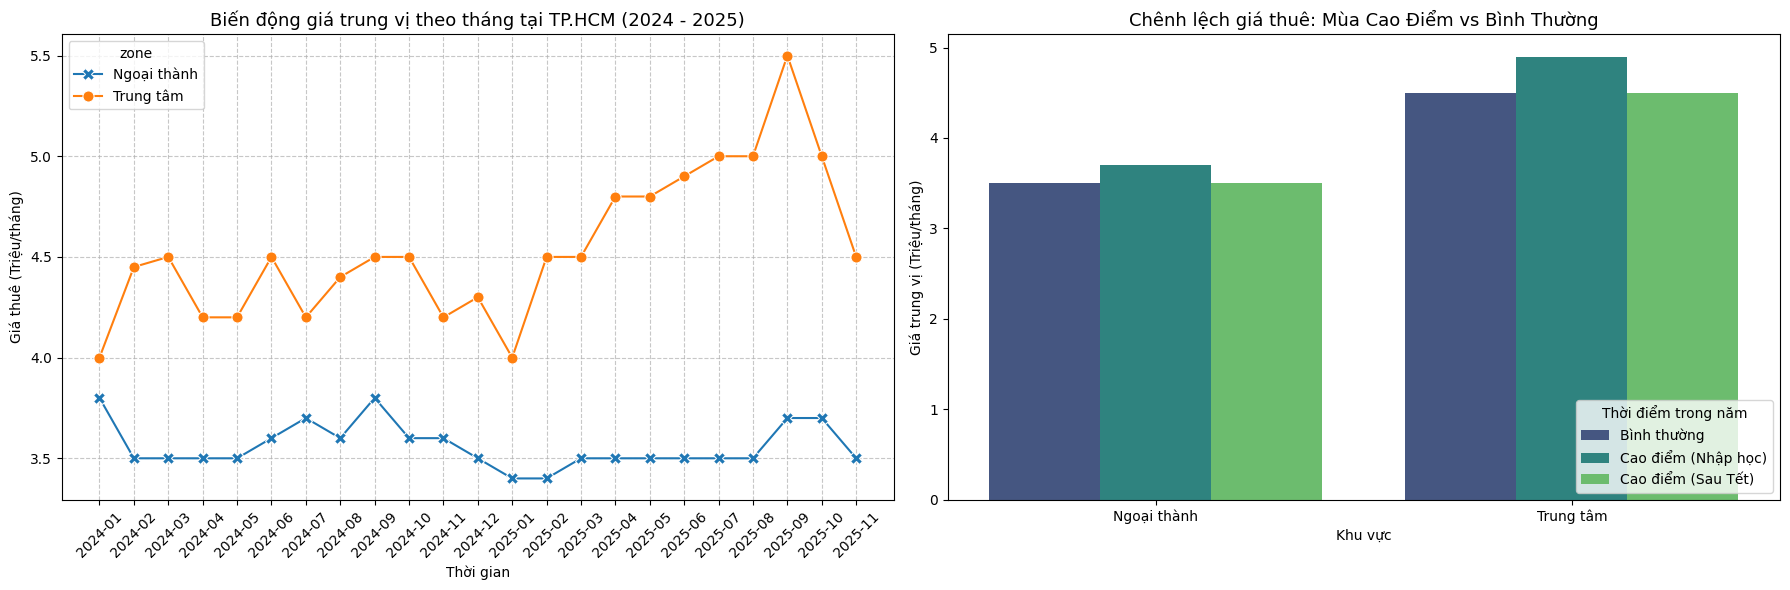

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(
    data=seasonal_price,
    x='month_year',
    y='price',
    hue='zone',
    style='zone',
    markers={'Trung tâm': 'o', 'Ngoại thành': 'X'},
    dashes=False,
    markersize=8,
    ax=axes[0]
)

axes[0].set_title('Biến động giá trung vị theo tháng tại TP.HCM (2024 - 2025)', fontsize=13)
axes[0].set_ylabel('Giá thuê (Triệu/tháng)')
axes[0].set_xlabel('Thời gian')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.7)


sns.barplot(
    data=season_stats,
    x='zone',
    y='price',
    hue='season_type',
    palette='viridis',
    ax=axes[1]
)

axes[1].set_title('Chênh lệch giá thuê: Mùa Cao Điểm vs Bình Thường', fontsize=13)
axes[1].set_ylabel('Giá trung vị (Triệu/tháng)')
axes[1].set_xlabel('Khu vực')
axes[1].legend(title='Thời điểm trong năm', loc='lower right')
axes[1].grid(False)

plt.tight_layout()
plt.show()

#### 1. Nhận định về xu hướng giá theo thời gian 

* **Sự phân hóa rõ rệt giữa hai khu vực:**
  * Đầu năm 2024, chênh lệch giá giữa hai khu vực khá thấp (chỉ khoảng **200.000 - 500.000 VNĐ**).Điều này phản ánh sự cân bằng cung–cầu tương đối giữa hai khu vực trong giai đoạn đầu năm.
  * Tuy nhiên, bước sang năm 2025, khoảng cách này nới rộng đáng kể. Đỉnh điểm vào tháng 9/2025, giá thuê trung tâm cao hơn ngoại thành gần **2 triệu VNĐ** (5,5 triệu so với 3,7 triệu). Điều này cho thấy áp lực tăng giá chủ yếu dồn vào khu vực trung tâm.


* **Khu vực Ngoại thành - "Vùng bình ổn giá":**
  * Đường biểu diễn giá (màu xanh dương) gần như đi ngang, dao động rất nhẹ quanh mốc **3,5 triệu VNĐ/tháng**.
  * Thị trường này thể hiện sự ổn định tuyệt đối, không bị ảnh hưởng bởi các cơn sốt giá, phù hợp với nhóm khách hàng ưu tiên sự an toàn về tài chính.


* **Khu vực Trung tâm - "Biến động mạnh theo mùa":**
  * Năm 2024: Giá tăng giảm đan xen nhưng giữ nền trung bình khoảng **4,0 - 4,5 triệu VNĐ**.
  * Năm 2025: Giá bắt đầu leo thang từ tháng 2 và đạt mức cao nhất trong giai đoạn khảo sát (5,5 triệu VNĐ) vào tháng 9/2025.
  * Ngay sau khi đạt đỉnh mùa nhập học, giá lao dốc mạnh vào tháng 11/2025 (giảm về mức 4,5 triệu), cho thấy tính chất thời vụ cực cao.



#### 2. Tác động của mùa vụ 

* **Mùa Nhập học (Tháng 8-9-10):**
  * Đây là thời điểm giá thuê đắt đỏ nhất trong năm ở cả hai khu vực.
  * Tại trung tâm, giá trung vị mùa này (cột màu xanh đậm nhất) cao vượt trội so với mức bình thường, phản ánh nhu cầu khổng lồ từ sinh viên và tân sinh viên đổ về nhập học.


* **Mùa Sau Tết (Tháng 2-3):**
  * Trái với suy nghĩ phổ biến rằng "ra Tết giá tăng", dữ liệu  cho thấy giá thuê giai đoạn này khá bình ổn, gần như tương đương với các tháng bình thường.
  * Điều này cho thấy nguồn cung phòng sau Tết có thể khá dồi dào, giúp kìm hãm đà tăng giá dù nhu cầu tìm phòng cao.



#### 3. Khuyến nghị thực tế

* **Đối với người đi thuê:**
  * **Tránh thuê nhà trung tâm vào tháng 9:** Đây là "vùng đỉnh giá" (5,5 triệu VNĐ). Nếu có thể, hãy kiên nhẫn đợi đến **tháng 10 hoặc tháng 11**, bạn có thể tiết kiệm được tới **1 triệu VNĐ/tháng** cho cùng một căn phòng.
  * **Ngoại thành là giải pháp tiết kiệm:** Nếu công việc cho phép làm từ xa hoặc linh động, chuyển ra ngoại thành giúp cắt giảm gần **40% chi phí thuê nhà**, với mức giá ổn định suốt 2 năm qua.
  * **Thời điểm vàng:** Đi thuê nhà vào giai đoạn **sau Tết hoặc cuối năm** là lựa chọn thông minh để có mức giá tốt nhất.


* **Đối với chủ nhà và môi giới:**
  * **Khu vực Trung tâm:** Có thể áp dụng chiến lược tăng giá 10-15% vào mùa nhập học (tháng 8-9) vì thị trường chấp nhận mức giá cao. Tuy nhiên, cần có chính sách ưu đãi giảm giá vào các tháng cuối năm (tháng 11-12) để lấp đầy phòng trống khi nhu cầu giảm sâu.
  * **Khu vực Ngoại thành:** Do giá bị kìm hãm ở mức trần 3,5 - 3,8 triệu, chủ nhà không nên cạnh tranh bằng giá mà nên đầu tư thêm tiện ích (máy lạnh, nội thất cơ bản) để thu hút khách thuê.

## Câu 4. Phân cực giá trong cùng quận – chênh lệch giữa các tuyến đường lớn và hẻm nhỏ

**Câu hỏi:** Mức độ chênh lệch giá thuê (đơn giá trên ) giữa nhà **Mặt tiền** và nhà trong **Hẻm** tại các quận của TP.HCM diễn ra như thế nào? Liệu quy luật "nhà mặt tiền luôn đắt hơn nhà hẻm" có đúng tuyệt đối ở mọi khu vực, từ **Trung tâm** sầm uất ra đến **Ngoại thành** hay không?

**Tại sao câu hỏi này quan trọng?**

* **Định hướng đầu tư (Cho nhà đầu tư):** Giúp xác định phân khúc nào mang lại tỷ suất lợi nhuận/m2 tốt hơn. Nên đầu tư nhà phố mặt tiền hay xây dựng chuỗi phòng trọ/chung cư mini trong hẻm tại các khu vực vùng ven?
* **Tối ưu ngân sách (Cho người thuê kinh doanh):** Giúp chủ doanh nghiệp nhỏ (F&B, thời trang) cân nhắc xem việc trả thêm chi phí cho mặt tiền ở trung tâm có thực sự đáng giá so với việc thuê hẻm lớn xe hơi hay không.
* **Hiểu rõ định giá thị trường:** Phát hiện các "nghịch lý" giá (nơi giá hẻm đắt hơn mặt tiền) để tránh bị hớ khi thương lượng giá thuê, đồng thời hiểu rõ đặc thù cung cầu của từng quận.

### A. Process 

Để đảm bảo tính chính xác và công bằng khi so sánh giá giữa "Hẻm" và "Mặt tiền", quy trình xử lý dữ liệu được thực hiện qua 4 bước nghiêm ngặt sau:

1.  **Chuẩn hóa địa danh (Quận/Huyện):**
    * Sử dụng hàm `clean_district_hcm` để đưa tất cả các biến thể tên quận (ví dụ: "q1", "Q.1", "Quận 1") về định dạng chuẩn thống nhất (ví dụ: "Quận 1").

2.  **Phân loại Hẻm và Mặt tiền (Có xử lý ngoại lệ):**
    * Sử dụng hàm `classify_street_type` để quét từ khóa trong địa chỉ và mô tả.
    * **Xử lý đặc biệt:** Với các địa chỉ chứa dấu xuyệt `/` (thường là hẻm), thuật toán sẽ kiểm tra đối chiếu với danh sách **"Tên đường ngày tháng"** (như đường 3/2, 30/4, 19/5...). Nếu trùng khớp, hệ thống sẽ giữ nguyên là Mặt tiền thay vì phân loại nhầm thành Hẻm.
3.  **Lọc dữ liệu "So sánh công bằng" :**
    * Tạo khóa định danh duy nhất: `Quận + Tên đường`.
    * **Nguyên tắc lọc:** Chỉ giữ lại những con đường tồn tại đồng thời cả hai loại hình (Hẻm và Mặt tiền) trong dữ liệu. Loại bỏ các con đường chỉ có một trong hai để tránh sai lệch do chênh lệch vị trí địa lý.

In [31]:
def classify_street_type(row):
    address = str(row['location']).lower() if pd.notnull(row['location']) else ''
    title = str(row['description']).lower() if pd.notnull(row['description']) else ''
    full_text = address + " " + title
    
    alley_keywords = ['hẻm', 'ngõ', 'ngách', 'hẽm', 'gần mặt', 'sau lưng', 'cách mặt']
    if any(kw in full_text for kw in alley_keywords):
        return 'Hẻm (Alley)'

    if pd.notnull(row['location']):
        location_str = str(row['location']).lower()
        
        date_streets = ['3/2', '30/4', '19/5', '1/5', '2/9', '23/9', '26/3', '23/10']
        matches = re.findall(r'\d+\/\d+', location_str)
        
        for m in matches:
            if m not in date_streets:
                return 'Hẻm (Alley)'

    main_street_keywords = ['mặt tiền', 'mặt phố', 'mt đường', 'phố', 'đường chính']
    if any(kw in full_text for kw in main_street_keywords):
        return 'Mặt tiền (Main Street)'

    return 'Khác (Unknown)'
def clean_district_hcm(addr):
    if not isinstance(addr, str): return None
    addr = addr.lower()
    
    mapping = {
        'quận 1': ['quận 1', 'q1', 'q.1'],
        'quận 2': ['quận 2', 'q2', 'q.2'],
        'quận 3': ['quận 3', 'q3', 'q.3'],
        'quận 4': ['quận 4', 'q4', 'q.4'],
        'quận 5': ['quận 5', 'q5', 'q.5'],
        'quận 6': ['quận 6', 'q6', 'q.6'],
        'quận 7': ['quận 7', 'q7', 'q.7'],
        'quận 8': ['quận 8', 'q8', 'q.8'],
        'quận 9': ['quận 9', 'q9', 'q.9'],
        'quận 10': ['quận 10', 'q10', 'q.10'],
        'quận 11': ['quận 11', 'q11', 'q.11'],
        'quận 12': ['quận 12', 'q12', 'q.12'],
        'bình thạnh': ['bình thạnh'],
        'tân bình': ['tân bình'],
        'tân phú': ['tân phú'],
        'phú nhuận': ['phú nhuận'],
        'gò vấp': ['gò vấp'],
        'bình tân': ['bình tân'],
        'thủ đức': ['thủ đức'],
        'bình chánh': ['bình chánh'],
        'nhà bè': ['nhà bè'],
        'hóc môn': ['hóc môn'],
        'củ chi': ['củ chi'],
        'cần giờ': ['cần giờ']
    }
    
    for standard, variations in mapping.items():
        for var in variations:
            if re.search(r'\b' + re.escape(var) + r'\b', addr):
                return standard.title()
    return None

df['street_type'] = df.apply(classify_street_type, axis=1)
df['district_clean'] = df['address'].apply(clean_district_hcm) 
df['price_per_m2'] = df['price'] / df['area']

df_clean = df.dropna(subset=['district_clean', 'street_name', 'price_per_m2']).copy()
df_clean = df_clean[
    (df_clean['street_type'].isin(['Hẻm (Alley)', 'Mặt tiền (Main Street)'])) & 
    (df_clean['street_name'].str.len() > 3) 
]

df_clean['unique_street_key'] = df_clean['district_clean'] + " - " + df_clean['street_name']

street_counts = df_clean.groupby('unique_street_key')['street_type'].nunique()
valid_streets = street_counts[street_counts == 2].index.tolist()

df_final = df_clean[df_clean['unique_street_key'].isin(valid_streets)].copy()

print(f"Tổng số tin đăng: {len(df)}")
print(f"Số tin sau khi lọc đường có cả Hẻm & Mặt tiền: {len(df_final)}")
print(f"Số lượng con đường thỏa mãn (để so sánh): {len(valid_streets)}")


Tổng số tin đăng: 24121
Số tin sau khi lọc đường có cả Hẻm & Mặt tiền: 5112
Số lượng con đường thỏa mãn (để so sánh): 408


### B. Analysis 

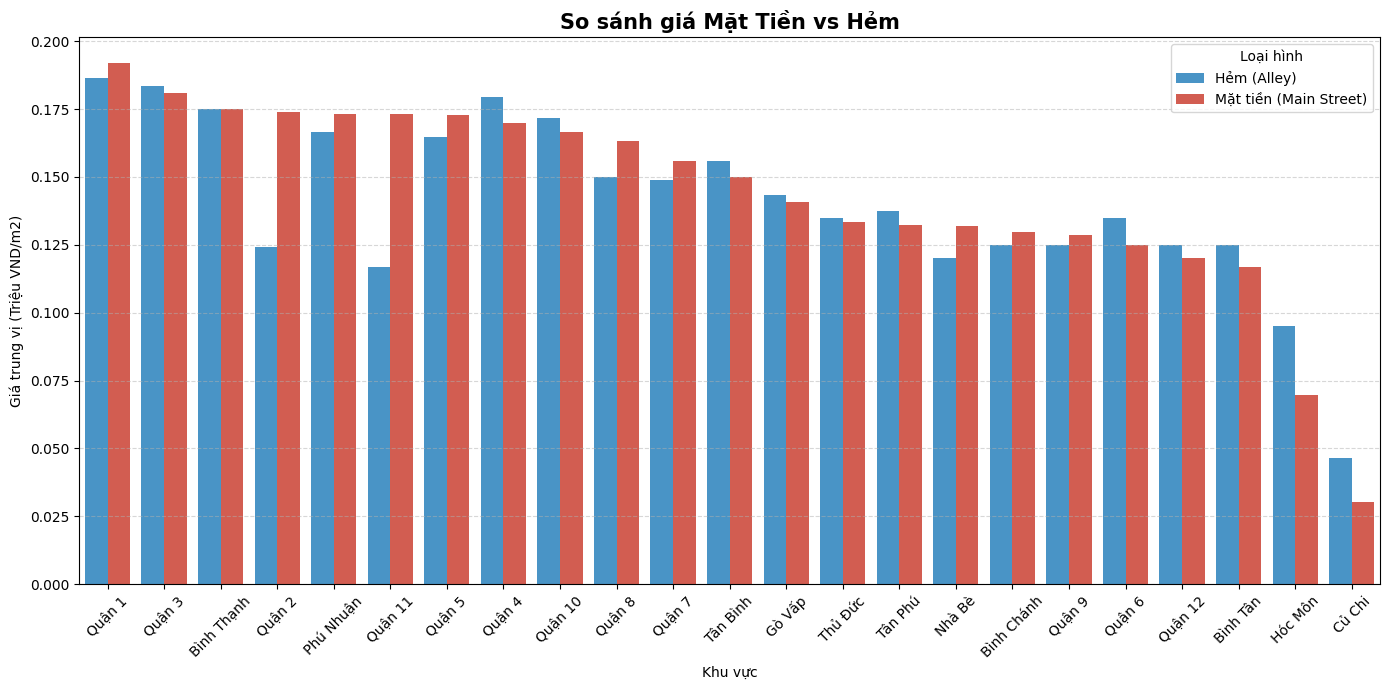

In [32]:

pivot_table = df_final.groupby(['district_clean', 'street_type'])['price_per_m2'].median().reset_index()
order_list = pivot_table[pivot_table['street_type'] == 'Mặt tiền (Main Street)'] \
             .sort_values('price_per_m2', ascending=False)['district_clean']

plt.figure(figsize=(14, 7))
sns.barplot(
    data=pivot_table, 
    x='district_clean', 
    y='price_per_m2', 
    hue='street_type',
    order=order_list,
    palette={'Hẻm (Alley)': '#3498db', 'Mặt tiền (Main Street)': '#e74c3c'}
)

plt.title('So sánh giá Mặt Tiền vs Hẻm', fontsize=15, fontweight='bold')
plt.ylabel('Giá trung vị (Triệu VND/m2)')
plt.xlabel('Khu vực')
plt.xticks(rotation=45)
plt.legend(title='Loại hình')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 1. Nhận xét tổng quan

Biểu đồ cho thấy **giá nhà mặt tiền nhìn chung cao hơn nhà trong hẻm** tại hầu hết các khu vực, phản ánh đúng quy luật thị trường khi nhà mặt tiền có lợi thế về kinh doanh, khả năng tiếp cận giao thông và tính thanh khoản. Tuy nhiên, **mức chênh lệch giữa hai loại hình không đồng đều**, phụ thuộc mạnh vào vị trí địa lý và mức độ phát triển đô thị của từng khu vực.

### 2. Nhận xét theo nhóm khu vực

* **Khu vực trung tâm (Quận 1, Quận 3, Bình Thạnh, Phú Nhuận)**
  Có mức giá cao nhất cho cả hai loại hình. Đáng chú ý, **giá nhà trong hẻm tại khu vực trung tâm vẫn rất cao**, và chênh lệch với nhà mặt tiền tương đối nhỏ. Điều này cho thấy **giá trị vị trí vượt trội**, khiến yếu tố “mặt tiền” không còn là yếu tố quyết định tuyệt đối.

* **Khu vực cận trung tâm (Quận 2, Quận 7, Quận 10, Quận 11)**
  Giá nhà mặt tiền cao hơn hẻm rõ rệt hơn so với khu trung tâm. Điều này phản ánh **vai trò của mặt tiền trong việc gia tăng giá trị khai thác thương mại**, đặc biệt tại các trục đường lớn và khu dân cư đang phát triển.

* **Khu vực ngoại thành (Bình Chánh, Quận 9, Quận 12, Bình Tân, Hóc Môn, Củ Chi)**
  Có mức giá thấp nhất. Chênh lệch giữa mặt tiền và hẻm nhỏ, thậm chí ở một số nơi giá hẻm xấp xỉ hoặc cao hơn mặt tiền. Điều này cho thấy **hạ tầng và khoảng cách đến trung tâm quan trọng hơn loại hình đường**, khi nhu cầu ở thực chiếm ưu thế so với nhu cầu kinh doanh.

### 3. Insight quan trọng

* **Vị trí quan trọng hơn mặt tiền:**
  Ở khu vực trung tâm, nhà hẻm vẫn giữ giá cao, chứng tỏ **vị trí địa lý có tác động mạnh hơn yếu tố mặt tiền**.

* **Mặt tiền tạo giá trị rõ nhất ở khu đang phát triển:**
  Tại các quận cận trung tâm, chênh lệch giá lớn cho thấy **nhà mặt tiền có lợi thế khai thác kinh doanh và đầu tư sinh lời**.

* **Ngoại thành thiên về nhu cầu ở thực:**
  Ở các huyện ngoại thành, nhà mặt tiền không tạo ra lợi thế giá đáng kể, phản ánh thị trường **hướng đến nhu cầu sinh sống hơn là thương mại**.

* **Cơ hội đầu tư**

  * Nhà hẻm khu trung tâm: **phù hợp đầu tư dài hạn, giữ giá tốt**.
  * Nhà mặt tiền khu cận trung tâm: **phù hợp đầu tư khai thác dòng tiền**.
  * Ngoại thành: **phù hợp người mua ở thực, ít lợi thế đầu cơ ngắn hạn**.


## Câu hỏi 5: Liệu có yếu Tố Mùa Vụ Trong Giá Thuê Phòng Trọ tại TP.HCM?
**Cụ thể:** **Giá thuê phòng trọ tại TP.HCM có sự thay đổi theo các tháng trong năm hay không?**

Tập trung làm rõ:
* Có tồn tại tháng nào ghi nhận mức giá thuê cao hơn đáng kể so với các tháng còn lại hay không?
* Các biến động này có phản ánh yếu tố **mùa vụ (seasonality)** của thị trường bất động sản cho thuê hay không?

#### 2. Lợi ích của việc tìm ra câu trả lời
Việc xác định sự biến động giá thuê theo thời gian mang lại những giá trị thực tiễn sau:

* **Đối với người thuê nhà:** Lựa chọn được "thời điểm vàng" để thuê trọ với chi phí tối ưu nhất.
* **Đối với chủ nhà/Người đăng tin:** Có cơ sở dữ liệu để điều chỉnh mức giá cạnh tranh và phù hợp với nhu cầu thị trường tại từng thời điểm.
* **Cái nhìn sâu sắc về thị trường:** Hiểu rõ các động lực thúc đẩy giá (ví dụ: mùa nhập học của sinh viên vào tháng 8-9 hoặc làn sóng di cư lao động sau Tết).
* **Về mặt kỹ thuật (Data Science):** 
    * Cải thiện quá trình **Xây dựng đặc trưng (Feature Engineering)** bằng cách thêm các biến thời gian.
    * Tăng độ chính xác cho các mô hình dự báo giá (Predictive Models) nhờ xử lý được tính mùa vụ.

### 3. Phương pháp phân tích dữ liệu
Để trả lời câu hỏi trên, quy trình phân tích sẽ được thực hiện qua các bước:

#### Bước 1: Tiền xử lý và Trích xuất đặc trưng
* Chuyển đổi dữ liệu ngày đăng tin sang định dạng `datetime`.
* Trích xuất các thuộc tính: **Tháng (Month)**, **Quý (Quarter)**, hoặc **Mùa trong năm**.

#### Bước 2: Thống kê mô tả và Nhóm dữ liệu
* Sử dụng phương pháp **Groupby** theo tháng.
* Tính toán các chỉ số đại diện:
    * **Giá trung vị (Median Price):** Hạn chế ảnh hưởng của các giá trị cực đoan (outliers).
    * **Giá trên mỗi mét vuông ($Price/m^2$):** Giúp so sánh công bằng giữa các loại diện tích khác nhau.

#### Bước 3: Phân tích xu hướng (Visual Analysis)
* Sử dụng biểu đồ đường (Line chart) hoặc biểu đồ cột (Bar chart) để quan sát sự biến đổi qua 12 tháng.
* 

#### Bước 4: Kiểm soát biến gây nhiễu
* Phân tách dữ liệu theo từng **Quận/Huyện** để đảm bảo biến động giá là do yếu tố thời gian chứ không phải do sự thay đổi về tỷ lệ tin đăng giữa các khu vực.
* So sánh các đặc điểm phòng (nội thất, loại hình) để đảm bảo tính đồng nhất khi diễn giải kết quả.

#### **Đọc file**

In [33]:
df = pd.read_csv("../Data/processed.csv")

#### **Tính thống kê theo tháng**
Ta tổng hợp theo `month` và tính:
- `median_price`: giá trung vị theo tháng 
- `mean_price`: giá trung bình
- `n_ads`: số lượng tin đăng theo tháng 

In [34]:
monthly = (
    df.groupby("month")
    .agg(
        n_ads=("price", "size"),
        median_price=("price", "median"),
        mean_price=("price", "mean"),
        q1=("price", lambda s: s.quantile(0.25)),
        q3=("price", lambda s: s.quantile(0.75)),
    )
    .reset_index()
    .sort_values("month")
)

display(monthly)

,month,n_ads,median_price,mean_price,q1,q3
0,1,479,3.70,3.692610,3.00000,4.4
1,2,1216,3.70,3.781924,3.00000,4.5
2,3,2154,3.80,3.874962,3.00000,4.5
3,4,1914,3.70,3.729712,3.00000,4.5
4,5,1978,3.80,3.900001,3.00000,4.6
5,6,1728,3.85,3.873998,3.00000,4.8
6,7,2257,3.80,3.909258,3.00000,4.7
7,8,2274,4.00,3.974295,3.00000,5.0
8,9,1713,4.10,4.132977,3.10000,5.2
9,10,2258,4.00,4.026250,3.11925,5.0


#### **Line chart: Xu hướng giá trung vị theo tháng**
Biểu đồ đường giúp quan sát nhanh:
- tháng nào có median cao nhất
- mức dao động theo tháng có rõ ràng hay không

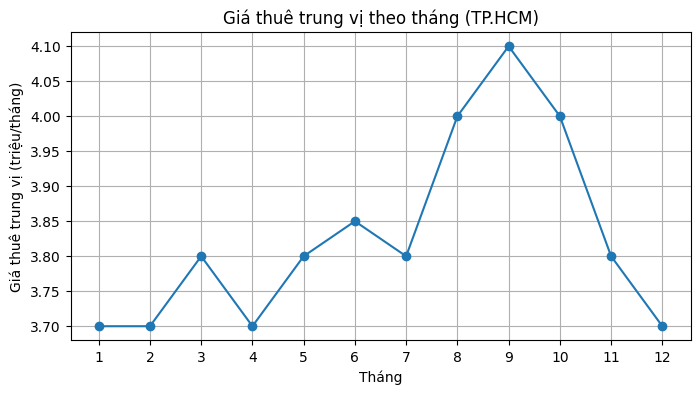

In [35]:
plt.figure(figsize=(8,4))
plt.plot(monthly["month"], monthly["median_price"], marker="o")
plt.xticks(range(1,13))
plt.xlabel("Tháng")
plt.ylabel("Giá thuê trung vị (triệu/tháng)")
plt.title("Giá thuê trung vị theo tháng (TP.HCM)")
plt.grid(True)
plt.show()

#### **Boxplot: Phân bố giá theo tháng**
Boxplot giúp đánh giá “cao hơn đáng kể” theo nghĩa phân bố:
- median theo tháng
- độ biến thiên (IQR)
- so sánh mức giá cao/thấp giữa các tháng một cách trực quan

C:\Users\vuphu\AppData\Local\Temp\ipykernel_9124\1935641020.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


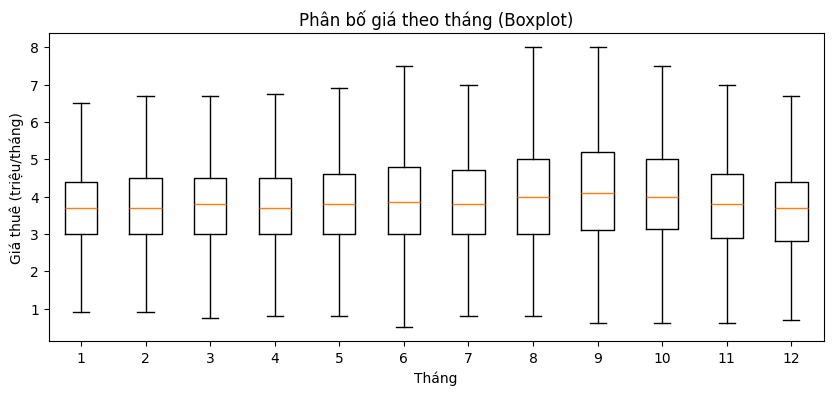

In [36]:
plt.figure(figsize=(10,4))
plt.boxplot(
    [df.loc[df["month"] == m, "price"].dropna() for m in range(1, 13)],
    labels=list(range(1, 13)),
    showfliers=False
)
plt.xlabel("Tháng")
plt.ylabel("Giá thuê (triệu/tháng)")
plt.title("Phân bố giá theo tháng (Boxplot)")
plt.show()

##### **Phân tích và nhận xét**

##### 1. Kết luận chính: Sự tồn tại của chu kỳ mùa vụ
Dựa trên dữ liệu `median_price` (giá trung vị) theo tháng, thị trường cho thấy một lộ trình biến động rõ rệt, không phải là sự dao động ngẫu nhiên. Đặc biệt, **tháng 9** được xác định là đỉnh điểm của năm.

**Lộ trình biến động cụ thể:**
* **Giai đoạn Thấp điểm (Tháng 1 – 2 – 4 – 12):** Giá chạm đáy, duy trì quanh mức **3.70 triệu**.
* **Giai đoạn Ổn định (Tháng 3 – 5 – 7 – 11):** Giá đi ngang quanh mức **3.80 triệu**.
* **Giai đoạn Tăng trưởng (Tháng 6 – 8):** Bắt đầu nhích lên từ 3.85 đến 4.00 triệu.
* **Giai đoạn Đỉnh điểm (Tháng 9 – 10):** Tháng 9 đạt cao nhất toàn năm với **4.10 triệu**, tháng 10 giữ mức cao 4.00 triệu trước khi thoái lui.

> **Kết luận:** Có sự thay đổi theo tháng rõ rệt. Cụm tháng 8–10 tạo thành một "mùa cao điểm" với đỉnh nhọn tập trung vào tháng 9.

##### 2. Đánh giá mức độ "Tăng trưởng đáng kể"
Để xác định xem mức tăng này có thực sự ý nghĩa về mặt thống kê và thực tế hay không, chúng ta so sánh mức chênh lệch giữa các cột mốc:

* **So với đáy (3.70 triệu):** Đỉnh tháng 9 tăng **0.40 triệu (~10.8%)**.
* **So với mặt bằng phổ biến (3.80 triệu):** Đỉnh tháng 9 cao hơn **0.30 triệu (~7.9%)**.

Trong thị trường bất động sản cho thuê, mức biến động trên 10% trong vòng vài tháng được coi là **rất lớn**. Trên biểu đồ đường (line chart), điều này sẽ tạo ra một "ngọn núi" tách biệt hẳn so với phần còn lại của năm.

##### 3. Phân tích phân phối qua Boxplot: Phân khúc giá cao "nở ra"
Phân tích kỹ hơn vào các tứ phân vị (Q1, Q3) và khoảng biến thiên nội phần vị (IQR), chúng ta thấy một sự dịch chuyển không đồng đều giữa các nhóm giá:

| Chỉ số | Tháng Thấp điểm (T1) | Tháng Cao điểm (T9) | Biến động |
| :--- | :--- | :--- | :--- |
| **Q1 (Nhóm giá thấp)** | 3.0 triệu | 3.1 triệu | +0.1 (Ổn định) |
| **Q3 (Nhóm giá cao)** | 4.4 triệu | 5.2 triệu | **+0.8 (Tăng mạnh)** |
| **IQR (Độ phân tán)** | 1.4 | 2.1 | Mở rộng đáng kể |

**Diễn giải quan trọng:**
* **Phân khúc giá rẻ (Q1):** Gần như đứng yên. Điều này cho thấy nhóm nhà trọ/căn hộ bình dân có giá thuê rất cứng nhắc, ít chịu ảnh hưởng bởi mùa vụ.
* **Phân khúc cao cấp/tiện nghi (Q3):** Là động lực chính kéo giá trung bình toàn thị trường lên. Vào tháng 9, nhóm này không chỉ tăng giá mà còn đa dạng hơn về mức giá (IQR tăng từ 1.4 lên 2.1).
* **Kết luận:** Mùa cao điểm không kéo toàn bộ thị trường lên đều, mà chủ yếu tác động mạnh vào phần trên của phân phối.

##### 4. Hiện tượng Đuôi phải (Right-Skew) và Tác động của nhóm giá cao
Quan sát mối quan hệ giữa **Mean (Trung bình)** và **Median (Trung vị)**:
* Tại mọi thời điểm, **Mean luôn lớn hơn Median** (Ví dụ T9: 4.133 > 4.10).
* **Ý nghĩa:** Thị trường luôn tồn tại một nhóm tin đăng có giá cực cao kéo giá trung bình lên.
* Vào tháng 9, khi cả Mean và Q3 cùng tăng mạnh, điều đó củng cố giả thuyết rằng: *Đà tăng của mùa cao điểm nằm tập trung ở phân khúc trung và cao cấp.*

##### 5. Độ tin cậy của dữ liệu: Số lượng tin đăng (n_ads)
Một nghi ngại thường gặp là "Giá cao do có quá ít dữ liệu gây nhiễu". Tuy nhiên, dữ liệu `n_ads` đã bác bỏ điều này:

* **Tháng 1:** 479 tin (Thấp nhất - có thể gây nhiễu nhưng vẫn khớp với xu hướng thấp điểm).
* **Tháng 8 & 10:** ~2,250 tin (Rất cao).
* **Tháng 9 (Đỉnh giá):** **1,713 tin**.

Với hơn 1,700 mẫu dữ liệu trong tháng 9, con số Median 4.10 là **cực kỳ đáng tin cậy** về mặt thống kê. Nó phản ánh đúng thực tế thị trường chứ không phải là sai số do cỡ mẫu nhỏ.

##### 6. Giải thích cơ chế thị trường (Contextual Analysis)
Mẫu hình này khớp hoàn hảo với đặc thù kinh tế - xã hội tại TP.HCM:
1.  **Mùa nhập học (Tháng 8 - 9):** Hàng trăm ngàn sinh viên và người lao động mới đổ về thành phố. Nhu cầu tăng đột biến tạo áp lực lên nguồn cung, cho phép chủ nhà thiết lập mức giá cao hơn.
2.  **Sự dịch chuyển sau hè:** Giai đoạn thay đổi công việc hoặc kết thúc các hợp đồng thuê cũ thường rơi vào quý 3, làm tăng tính thanh khoản và biến động giá.
3.  **Tâm lý chấp nhận:** Nhóm người thuê có điều kiện tài chính hoặc đang trong tình thế cấp bách (phải có chỗ ở để kịp đi học/đi làm) sẵn sàng chấp nhận mức giá ở phân khúc Q3, dẫn đến việc phân khúc này "nở ra" mạnh mẽ.

##### 7. Tổng kết báo cáo
1.  **Tính mùa vụ:** Xác nhận có mùa vụ. Cụm cao điểm là **Tháng 8 – 10**.
2.  **Đỉnh giá:** Tháng 9 đạt **4.10 triệu** (tăng ~10.8% so với đáy).
3.  **Bản chất tăng trưởng:** Tăng chủ yếu ở phân khúc trung và cao cấp (Q3 tăng từ 4.4 lên 5.2), trong khi phân khúc giá rẻ khá ổn định.
4.  **Độ tin cậy:** Kết quả dựa trên quy mô mẫu lớn (>1,700 tin đăng vào tháng đỉnh điểm), đảm bảo tính đại diện cao.